In [1]:
import os
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

from concurrent.futures import ThreadPoolExecutor
from PIL import Image

from skimage.feature import local_binary_pattern, hog

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, precision_recall_fscore_support, roc_auc_score, RocCurveDisplay

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Dense, concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [2]:
BASE_PATH = r"D:\Data_and_AI\Datasets\Microscopic Images of Integrated Circuits\Files\Anomaly_train"
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32

In [3]:
# Create data generators
def create_data_generator(category, batch_size=BATCH_SIZE, shuffle=True):
    files = sorted([f for f in os.listdir(BASE_PATH) if f.startswith(category)])
    
    def generator():
        while True:
            if shuffle:
                np.random.shuffle(files)
            
            for i in range(0, len(files), batch_size):
                batch_files = files[i:i+batch_size]
                batch_images = []
                
                for filename in batch_files:
                    img = Image.open(os.path.join(BASE_PATH, filename)).convert('L')
                    img = img.resize(IMAGE_SIZE)
                    img_array = np.array(img) / 255.0  # Normalize here
                    batch_images.append(img_array)
                
                batch_x = np.array(batch_images).reshape(-1, *IMAGE_SIZE, 1)
                yield batch_x, batch_x  # Return same data for input and target
    
    return generator(), len(files)

In [4]:
# Create test datasets (small enough to fit in memory)
def load_test_data(category):
    files = sorted([f for f in os.listdir(BASE_PATH) if f.startswith(category)])
    images = []
    
    for filename in files:
        img = Image.open(os.path.join(BASE_PATH, filename)).convert('L')
        img = img.resize(IMAGE_SIZE)
        img_array = np.array(img) / 255.0
        images.append(img_array)
    
    return np.array(images).reshape(-1, *IMAGE_SIZE, 1)

In [5]:
print("Loading test data...")
X_test_normal = load_test_data('test_normal')
X_test_abnormal = load_test_data('test_abnormal')
X_test = np.concatenate([X_test_normal, X_test_abnormal])
y_test = np.concatenate([
    np.zeros(len(X_test_normal)), 
    np.ones(len(X_test_abnormal))
])
print(f"Test data loaded: {X_test.shape}")

Loading test data...
Test data loaded: (1388, 128, 128, 1)


## Testing

In [13]:
X_test_normal.shape

(1272, 128, 128, 1)

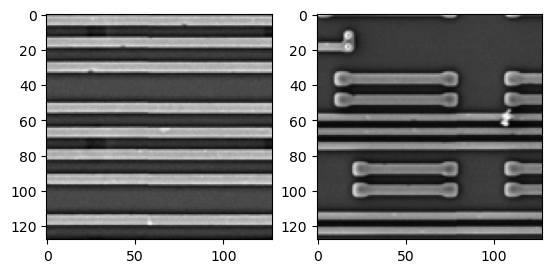

In [30]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(X_test_normal[0], cmap='grey')
plt.subplot(1,2,2)
plt.imshow(X_test_abnormal[12], cmap='grey');

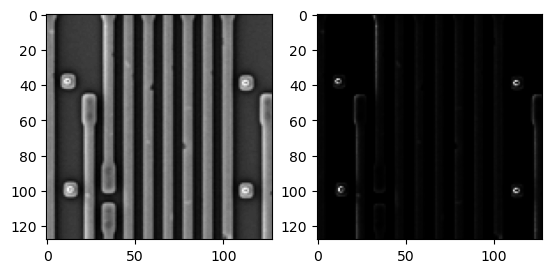

In [58]:
exp = X_test_normal[2]
exp_mean = np.mean(exp)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(exp, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(np.power(exp + exp_mean,10), cmap='grey');

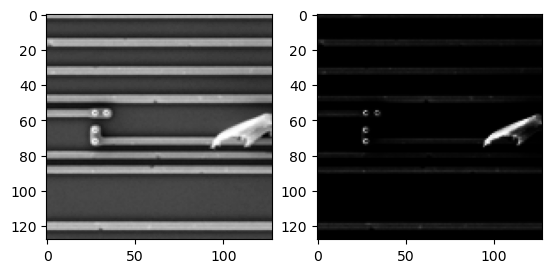

In [50]:
exp = X_test_abnormal[28]
exp_mean = np.mean(exp)

plt.figure()
plt.subplot(1,2,1)
plt.imshow(exp, cmap='grey')
plt.subplot(1,2,2)
plt.imshow(np.power(exp + exp_mean,10), cmap='grey');

In [10]:
# Create training data generator
train_gen, train_steps = create_data_generator('train_normal', batch_size=BATCH_SIZE)

In [90]:
input_img = Input(shape=(128, 128, 1))

# Encoder
x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.15)(x)  # 128 -> 64

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.2)(x)  # 64 -> 32

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.25)(x)  # 32 -> 16

# Added extra layer to further reduce dimensionality
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Dropout(0.3)(x)  # 16 -> 8

# Bottleneck is now 8×8×32 = 2,048 features (much smaller)
encoded = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)

# Decoder - symmetrical to encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(encoded)
x = UpSampling2D((2, 2))(x)  # 8 -> 16
x = Dropout(0.3)(x)

x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)
x = UpSampling2D((2, 2))(x)  # 16 -> 32
x = Dropout(0.25)(x)

x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)
x = UpSampling2D((2, 2))(x)  # 32 -> 64
x = Dropout(0.2)(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-5))(x)
x = UpSampling2D((2, 2))(x)  # 64 -> 128
x = Dropout(0.15)(x)

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
# Create and compile model
autoencoder = Model(input_img, decoded)

In [91]:
autoencoder.compile(optimizer='adam', loss='mse')

print(autoencoder.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 128, 128, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 128, 128, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 64, 64, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 16, 16, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 8, 8, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 8, 8, 16)            │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 8, 8, 32)            │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_15 (UpSampling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_32 (Dropout)                 │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_43 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_16 (UpSampling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_33 (Dropout)                 │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 32, 32, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 92,753 (362.32 KB)

 Trainable params: 92,753 (362.32 KB)

 Non-trainable params: 0 (0.00 B)

None


In [92]:
# Setup callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(
    monitor='loss',
    patience=3,  # Wait longer before stopping
    min_delta=0.0001,  # Only count improvements of at least 0.0001 as significant
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'best_autoencoder.keras',
    monitor='loss',
    verbose=1,
    save_best_only=True
)

In [93]:
# Calculate steps per epoch
steps_per_epoch = train_steps // BATCH_SIZE

# Train model using generator
history = autoencoder.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/10
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.0210
Epoch 1: loss improved from inf to 0.01471, saving model to best_autoencoder.keras
746/746 ━━━━━━━━━━━━━━━━━━━━ 980s 1s/step - loss: 0.0210
Epoch 2/10
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 546ms/step - loss: 0.0072
Epoch 2: loss improved from 0.01471 to 0.00682, saving model to best_autoencoder.keras
746/746 ━━━━━━━━━━━━━━━━━━━━ 407s 546ms/step - loss: 0.0072
Epoch 3/10
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - loss: 0.0061
Epoch 3: loss improved from 0.00682 to 0.00597, saving model to best_autoencoder.keras
746/746 ━━━━━━━━━━━━━━━━━━━━ 224s 300ms/step - loss: 0.0061
Epoch 4/10
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.0058
Epoch 4: loss improved from 0.00597 to 0.00567, saving model to best_autoencoder.keras
746/746 ━━━━━━━━━━━━━━━━━━━━ 215s 289ms/step - loss: 0.0058
Epoch 5/10
746/746 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - loss: 0.0054
Epoch 5: loss improved from 0.00567 to 0.00535, saving model to best_autoenco

In [97]:
# Calculate reconstruction error on test set
print("Calculating reconstruction errors...")
reconstructions = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - reconstructions), axis=(1,2,3))

# Load a small sample of training data for threshold calculation
print("Loading sample of training data for threshold calibration...")
train_sample_size = min(1000, train_steps)  # Use at most 1000 samples
train_sample_files = sorted([f for f in os.listdir(BASE_PATH) if f.startswith('train_normal')])[:train_sample_size]
train_sample = []
print("---------loaded-----------")

Calculating reconstruction errors...
44/44 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step
Loading sample of training data for threshold calibration...
---------loaded-----------


In [98]:
for filename in train_sample_files:
    img = Image.open(os.path.join(BASE_PATH, filename)).convert('L')
    img = img.resize(IMAGE_SIZE)
    img_array = np.array(img) / 255.0
    train_sample.append(img_array)

train_sample = np.array(train_sample).reshape(-1, *IMAGE_SIZE, 1)
train_reconstructions = autoencoder.predict(train_sample)
train_mse = np.mean(np.square(train_sample - train_reconstructions), axis=(1,2,3))


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step


In [99]:
# Set threshold as 95th percentile of training sample reconstruction errors
threshold = np.percentile(train_mse, 95)
y_pred = (mse > threshold).astype(int)

# Evaluate performance
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
auc = roc_auc_score(y_test, mse)

print(f"Threshold: {threshold:.6f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

Threshold: 0.008909
Precision: 0.1000
Recall: 0.1034
F1 Score: 0.1017
AUC-ROC: 0.4795


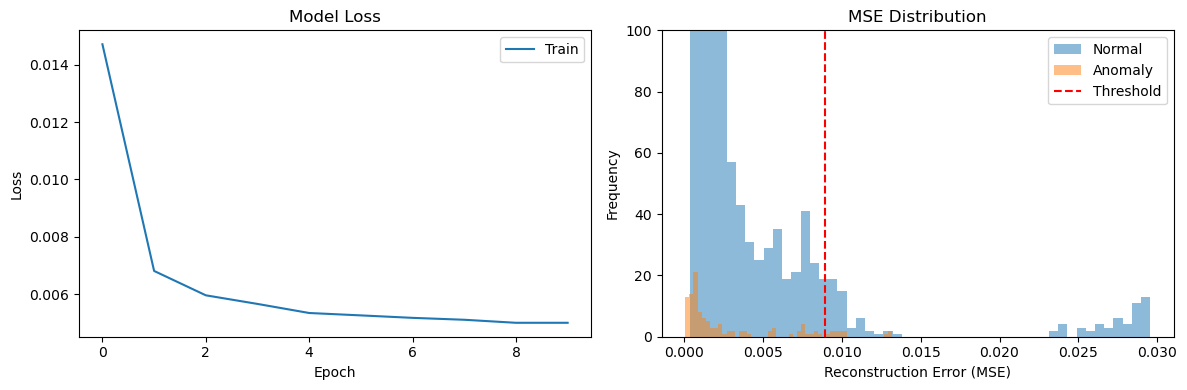

In [100]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

# Plot MSE distributions
plt.subplot(1, 2, 2)
plt.hist(mse[y_test==0], bins=50, alpha=0.5, label='Normal')
plt.hist(mse[y_test==1], bins=50, alpha=0.5, label='Anomaly')
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title('MSE Distribution')
plt.xlabel('Reconstruction Error (MSE)')
plt.ylabel('Frequency')
plt.ylim(0,100)
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
# Visualize some examples
def plot_results(original, reconstructed, mse_val, is_anomaly, pred_anomaly):
    plt.figure(figsize=(20, 4))
    
    plt.subplot(1, 4, 1)
    plt.imshow(original.reshape(128, 128), cmap='gray')
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(reconstructed.reshape(128, 128), cmap='gray')
    plt.title("Reconstructed")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    diff = np.abs(original - reconstructed).reshape(128, 128)
    plt.imshow(diff, cmap='hot')
    plt.title("Difference Map")
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.text(0.5, 0.5, f"MSE: {mse_val:.6f}\nTrue: {'Anomaly' if is_anomaly else 'Normal'}\nPred: {'Anomaly' if pred_anomaly else 'Normal'}", 
             horizontalalignment='center', verticalalignment='center', fontsize=14)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

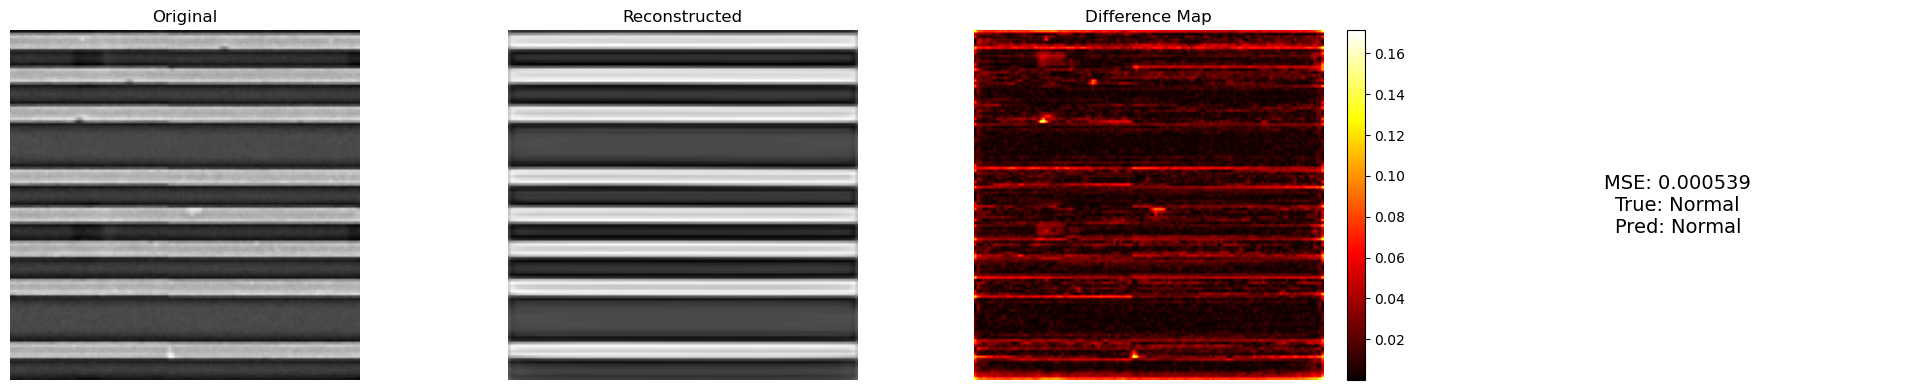

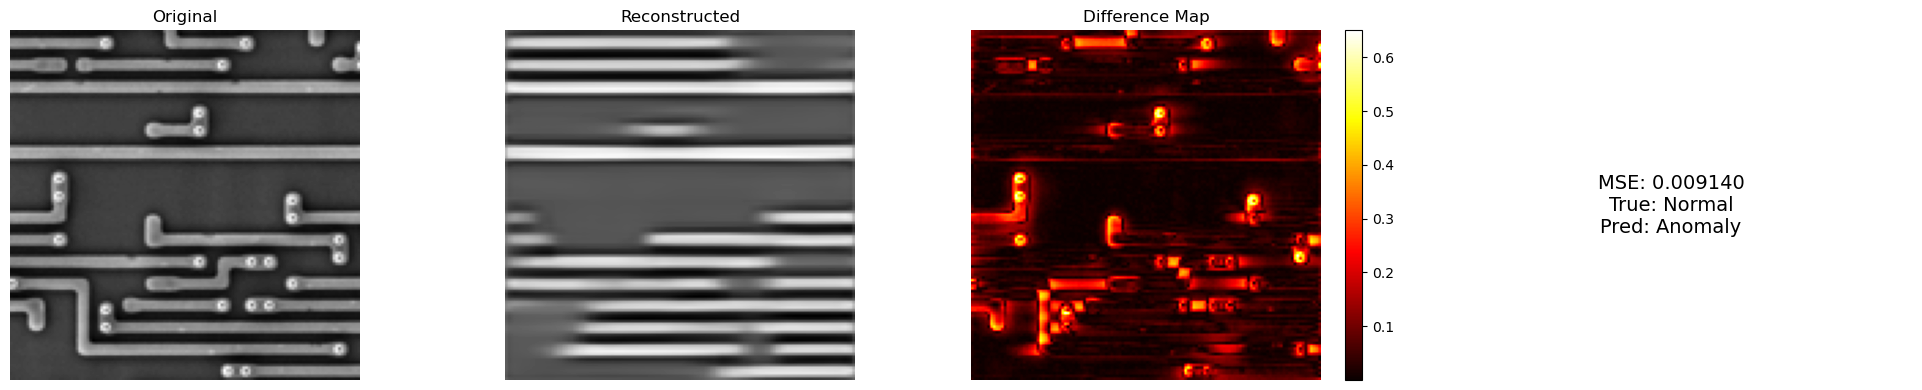

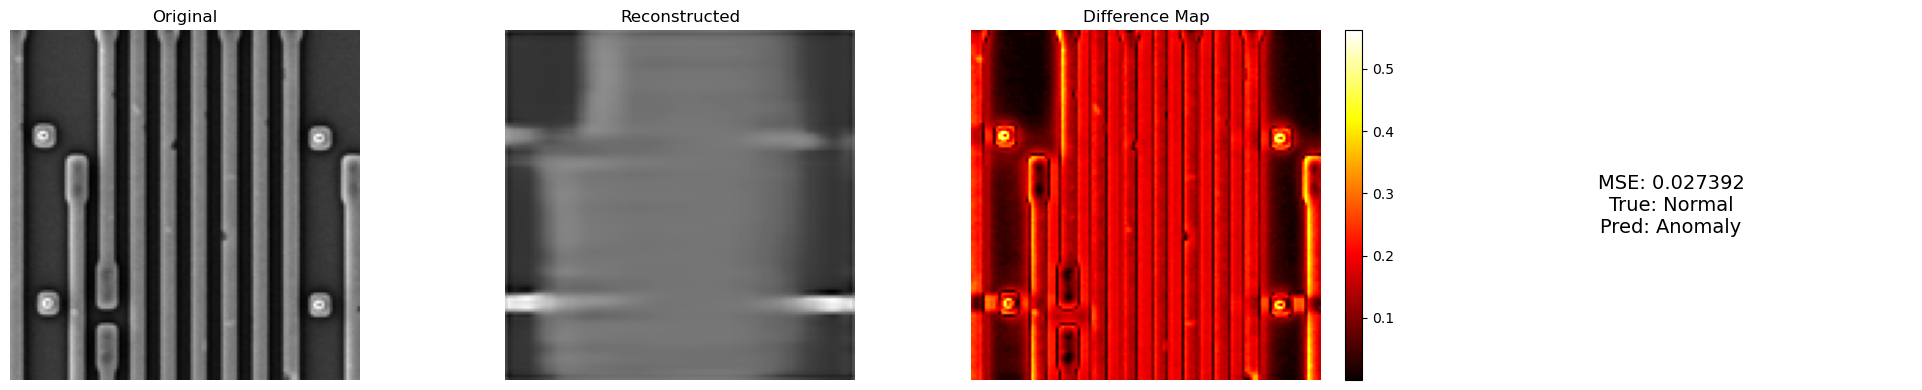

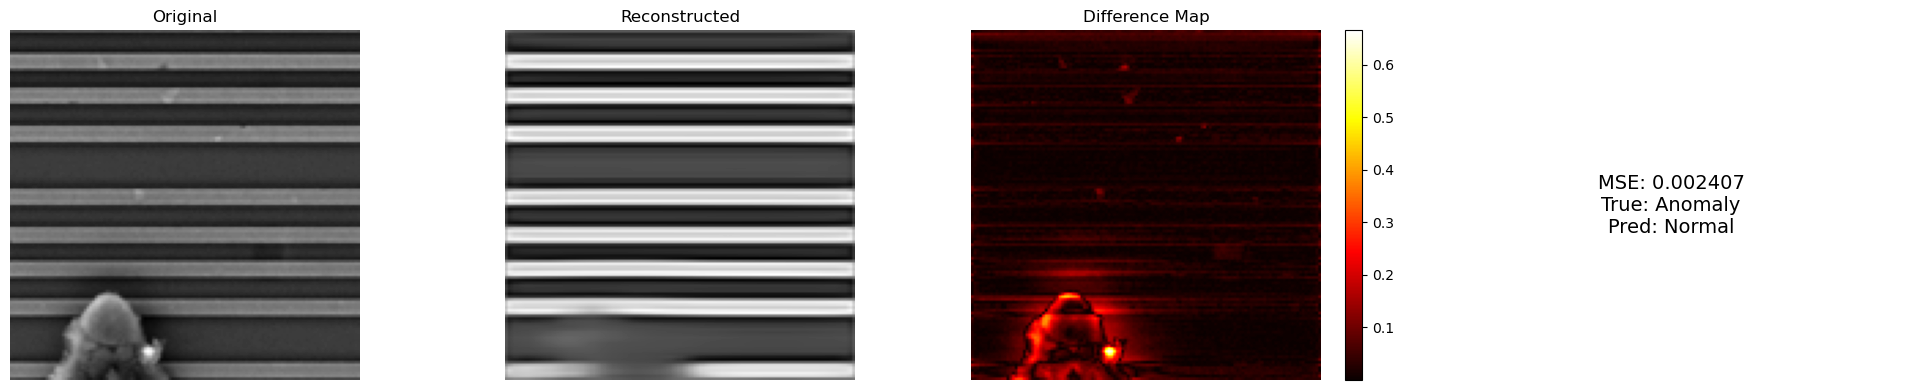

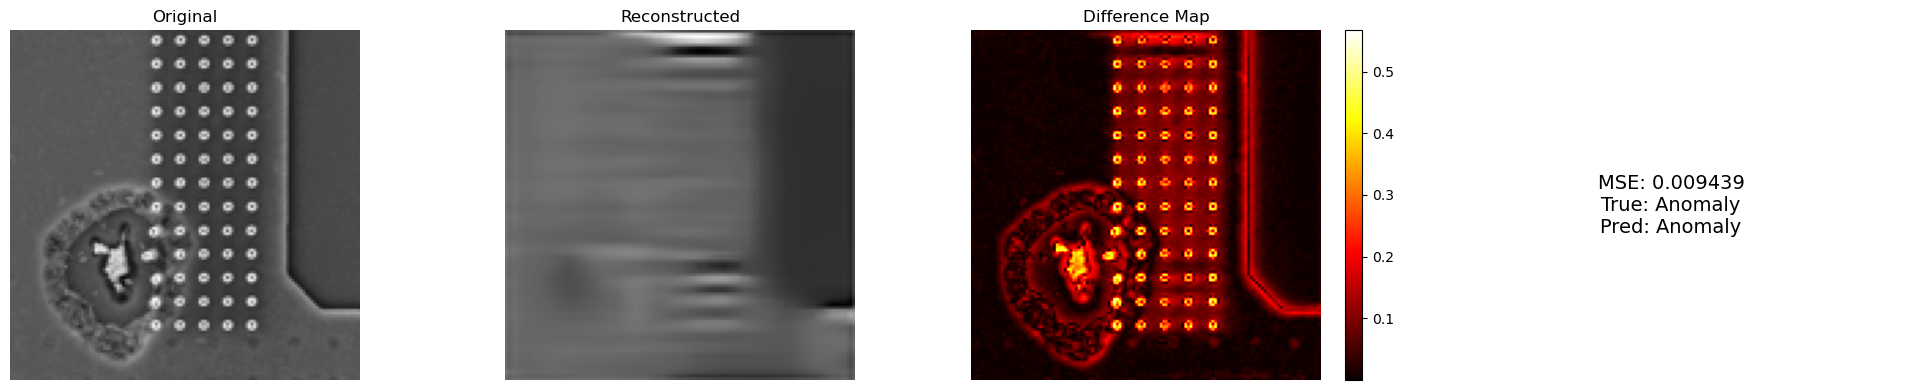

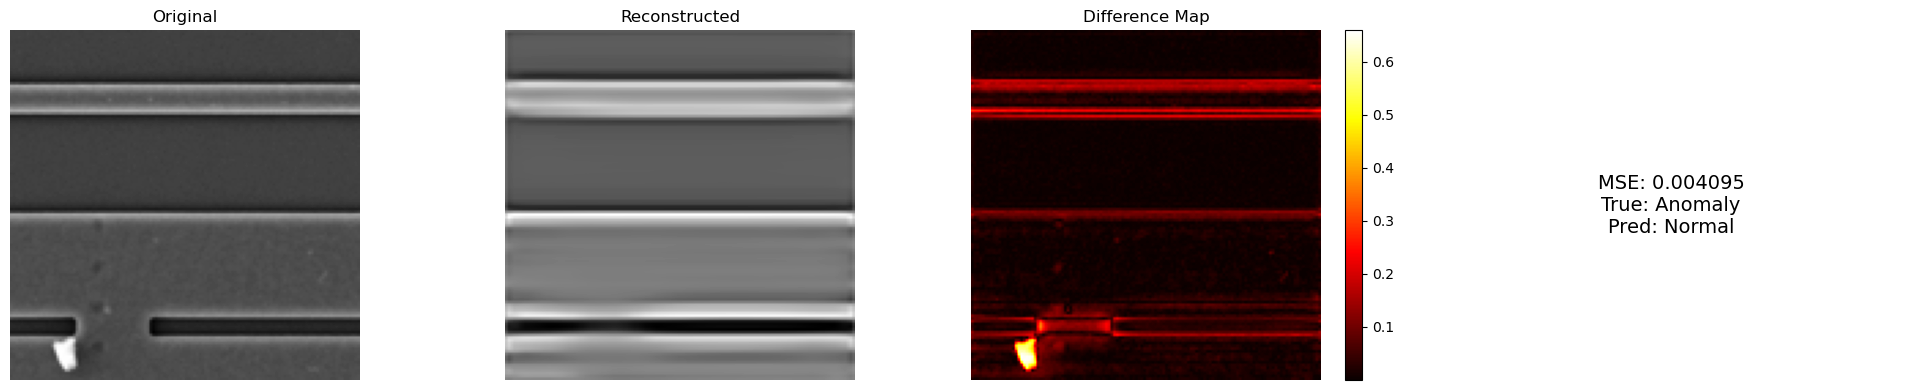

In [102]:
# Plot some normal and anomaly examples
normal_idx = np.where(y_test == 0)[0][:3]
anomaly_idx = np.where(y_test == 1)[0][:3]

for idx in normal_idx:
    plot_results(X_test[idx], reconstructions[idx], mse[idx], 
                 is_anomaly=(y_test[idx]==1), pred_anomaly=(y_pred[idx]==1))

for idx in anomaly_idx:
    plot_results(X_test[idx], reconstructions[idx], mse[idx], 
                 is_anomaly=(y_test[idx]==1), pred_anomaly=(y_pred[idx]==1))